Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# MLP genérica para solução do problemas das meias luas - Otimizador Adam

Neste exercício vamos treinar uma rede MLP com o algoritimo backpropagation utilizando o otimizador Adam para a solução do problema das meias luas.

In [56]:
import numpy as np
import matplotlib.pyplot as plt

Vamos gerar os dados de treinamento do problema das meias-luas.

In [57]:
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    # total de dados de treinamento
    Nt = NA + NB

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    x1A = rxy * np.cos(a)
    x2A = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((x1A, x2A, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    x1B = rxy * np.cos(a) + r1
    x2B = -rxy * np.sin(a) - r2
    dB = -np.ones((NB, 1))
    pontosB = np.hstack((x1B, x2B, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(x1A, x2A, ".b")
    ax1.plot(x1B, x2B, ".r")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

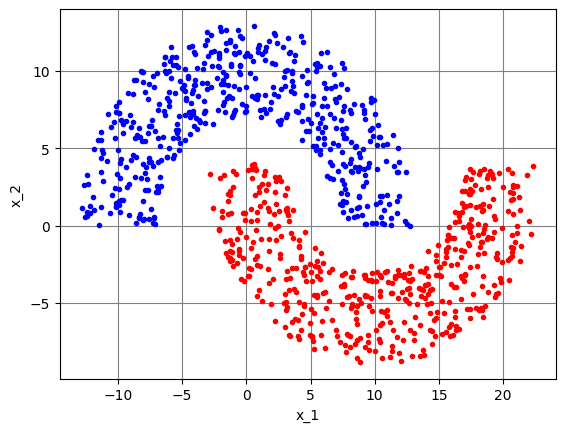

In [58]:
# número de pontos de treinamento da Região A
NA = 500

# número de pontos de treinamento da Região B
NB = 500

# número total de dados de treinamento
Nt = NA + NB

r1 = 10
r3 = 6
r2 = -4

dados_treino = meias_luas(NA, NB, r1, r2, r3)

In [59]:
# organizando os dados para entrada da MLP

# sinal de entrada
x = dados_treino[:, [0, 1]]

# sinal desejado
d = dados_treino[:, [2]]

# Exercício 1

Implemente uma função para treinamento de uma rede MLP genérica usando o algoritmo Adam, considerando a função de ativação $f(x) = \textnormal{tanh}(x)$ com derivada $f'(x) = 1 - \textnormal{tanh}^2(x)$ e função custo do MSE, como feito no exercício MLP 3.

Para definir a estrutura da rede, utilize uma entrada chamada `Nn` contendo o número de entradas da rede, seguido do número de neurônios de cada camada. Por exemplo: `Nn = [2, 3, 2, 1]` representa uma rede com duas entradas, duas camadas ocultas com 3 e 2 neurônios, respectivamente e um único neurônio na camada de saída.

Considere a seguinte assinatura para a função (note as entradas adicionais referentes aos hiperparâmetros do Adam):

```python
def redeMLP_Adam(x, d, Nn, eta, Nt, Nb, Ne, W0):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    beta1, beta2: fatores de esquecimento do otimizador Adam
                  (e.g., beta1 = beta2 = 0.99)
    epsilon: constante para evitar divisão por zero no Adam
             (e.g. epsilon = 1e-4)
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
       utilize um tensor de mesmas dimensões de W0
    """
```

Após implementação da função para treinamento, treine uma rede para solucionar o problemas das meias luas considerando os dados `x`e `d` criados anteriormente considerando a arquitetura `Nn = [2, 3, 5, 5, 2, 1]`. Faça um gráfico da função custo ao longo das épocas de treinamento.

## Resolução

In [60]:
import numpy as np

def redeMLP_Adam(x, d, Nn, eta, Nt, Nb, Ne, W0,
                 beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Treinamento de uma rede MLP genérica com o otimizador Adam.
    Função de ativação: tanh(x)
    Função custo: MSE
    """

    # --- Parâmetros iniciais ---
    L = len(Nn) - 1  # número de camadas com pesos
    W = np.copy(W0)
    m = np.zeros_like(W)
    v = np.zeros_like(W)
    J_MSE = np.zeros(Ne)

    # --- Funções auxiliares ---
    def f_ativ(x):  # tanh
        return np.tanh(x)

    def df_ativ(x):  # derivada da tanh
        return 1 - np.tanh(x)**2

    # --- Treinamento ---
    for epoca in range(Ne):
        # Embaralhar os dados a cada época
        idx = np.random.permutation(Nt)
        x = x[idx, :]
        d = d[idx, :]

        # Mini-batch training
        for k in range(0, Nt, Nb):
            xb = x[k:k+Nb, :]
            db = d[k:k+Nb, :]
            Nb_atual = xb.shape[0]

            # ---------- FORWARD ----------
            u = [None] * (L + 1)
            y = [None] * (L + 1)

            y[0] = xb.T  # entradas como colunas

            for j in range(L):
                # Adiciona bias
                yb = np.vstack((np.ones((1, Nb_atual)), y[j]))
                u[j+1] = W[:Nn[j+1], :Nn[j]+1, j] @ yb
                y[j+1] = f_ativ(u[j+1])

            # Saída da rede
            yL = y[L]

            # ---------- ERRO E CUSTO ----------
            e = db.T - yL
            J_batch = np.mean(e**2)
            J_MSE[epoca] += J_batch * Nb_atual / Nt

            # ---------- BACKPROP ----------
            delta = e * df_ativ(u[L])
            for j in range(L-1, 0, -1):
                delta = (W[:Nn[j+1], 1:Nn[j]+1, j].T @ delta) * df_ativ(u[j])

                # Gradiente dos pesos da camada j
                yb = np.vstack((np.ones((1, Nb_atual)), y[j-1]))
                grad_W = (delta @ yb.T) / Nb_atual

                # Atualização Adam
                m[:Nn[j], :Nn[j-1]+1, j-1] = (
                    beta1 * m[:Nn[j], :Nn[j-1]+1, j-1] +
                    (1 - beta1) * grad_W
                )
                v[:Nn[j], :Nn[j-1]+1, j-1] = (
                    beta2 * v[:Nn[j], :Nn[j-1]+1, j-1] +
                    (1 - beta2) * (grad_W ** 2)
                )

                # Correção de viés
                m_corr = m[:Nn[j], :Nn[j-1]+1, j-1] / (1 - beta1 ** (epoca + 1))
                v_corr = v[:Nn[j], :Nn[j-1]+1, j-1] / (1 - beta2 ** (epoca + 1))

                # Atualização dos pesos
                W[:Nn[j], :Nn[j-1]+1, j-1] -= eta * m_corr / (np.sqrt(v_corr) + epsilon)

            # Camada de saída
            yb = np.vstack((np.ones((1, Nb_atual)), y[L-1]))
            grad_W = (e * df_ativ(u[L])) @ yb.T / Nb_atual

            m[:Nn[L], :Nn[L-1]+1, L-1] = beta1 * m[:Nn[L], :Nn[L-1]+1, L-1] + (1 - beta1) * grad_W
            v[:Nn[L], :Nn[L-1]+1, L-1] = beta2 * v[:Nn[L], :Nn[L-1]+1, L-1] + (1 - beta2) * (grad_W ** 2)

            m_corr = m[:Nn[L], :Nn[L-1]+1, L-1] / (1 - beta1 ** (epoca + 1))
            v_corr = v[:Nn[L], :Nn[L-1]+1, L-1] / (1 - beta2 ** (epoca + 1))
            W[:Nn[L], :Nn[L-1]+1, L-1] -= eta * m_corr / (np.sqrt(v_corr) + epsilon)

        # Exibe progresso a cada 20 épocas
        if (epoca+1) % 20 == 0 or epoca == 0:
            print(f"Época {epoca+1}/{Ne} - MSE: {J_MSE[epoca]:.6f}")

    return J_MSE, W


In [61]:
# Converte rótulos 0,1 para -1,+1
d = 2*d - 1

# Arquitetura e hiperparâmetros
Nn = [2, 3, 5, 5, 2, 1]
eta = 0.005
Nb = 64
Ne = 400
Nt = x.shape[0]

# Pesos iniciais
L = len(Nn) - 1
W0 = np.zeros((np.max(Nn), np.max(Nn)+1, L))
for j in range(L):
    W0[:Nn[j+1], :Nn[j]+1, j] = np.random.randn(Nn[j+1], Nn[j]+1) * 0.1

# Treinamento
J_MSE, W_final = redeMLP_Adam(x, d, Nn, eta, Nt, Nb, Ne, W0)


Época 1/400 - MSE: 5.082998
Época 20/400 - MSE: 9.153997
Época 40/400 - MSE: 9.332047
Época 60/400 - MSE: 9.399744
Época 80/400 - MSE: 9.427450
Época 100/400 - MSE: 9.403963
Época 120/400 - MSE: 9.456807
Época 140/400 - MSE: 9.461285
Época 160/400 - MSE: 9.460667
Época 180/400 - MSE: 9.447087
Época 200/400 - MSE: 9.468444
Época 220/400 - MSE: 9.470085
Época 240/400 - MSE: 9.471307
Época 260/400 - MSE: 9.472251
Época 280/400 - MSE: 9.473012
Época 300/400 - MSE: 9.473578
Época 320/400 - MSE: 9.474038
Época 340/400 - MSE: 9.474402
Época 360/400 - MSE: 9.474693
Época 380/400 - MSE: 9.474926
Época 400/400 - MSE: 9.475116


# Exercício 2

Utilizando os seguintes dados de teste:

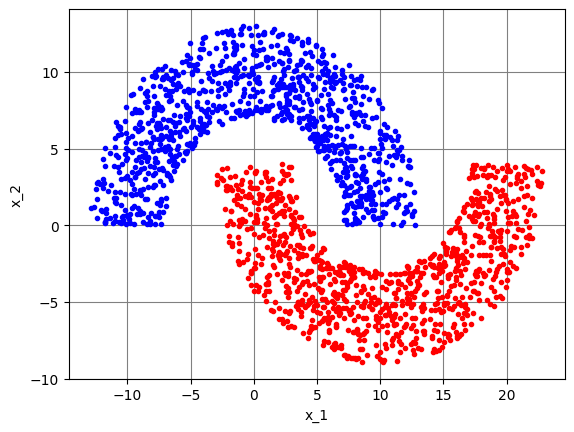

In [62]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

# entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada

# sinal desejado
dteste = dados_teste[:, 2].reshape(-1, 1)

Implemente uma função para teste da rede MLP treinada anteriormente, com a seguinte assinatura (note que pode ser usada a mesma função de teste implementada no exercício MLP 3):

``` python
def redeMLP_teste(x, d, W, Nn, Nteste):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época (mesmo formato do treinamento)
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    """
```

Em seguida, faça o teste da rede com os dados de teste, considerando a arquitetura `Nn = [2, 3, 5, 5, 2, 1]`, apresente a taxa de erro e a curva de separação das duas regiões obtidas com a rede treinada.

Por fim, compare o resultado obtido com essa arquitetura considerando a rede MLP treinada com gradiente descendente, implementada no exercício MLP 3.

## Resolução

In [63]:
def redeMLP_teste(x, d, W, Nn, Nteste):
    """
    Teste da MLP (mesmo formato do treinamento)
    """
    L = len(Nn) - 1
    y = x.T
    for j in range(L):
        yb = np.vstack((np.ones((1, y.shape[1])), y))
        u = W[:Nn[j+1], :Nn[j]+1, j] @ yb
        y = np.tanh(u)

    y = y.T
    e = d - y
    J_MSE = np.mean(e**2)
    return J_MSE, y


Taxa de erro no teste: 91.15%


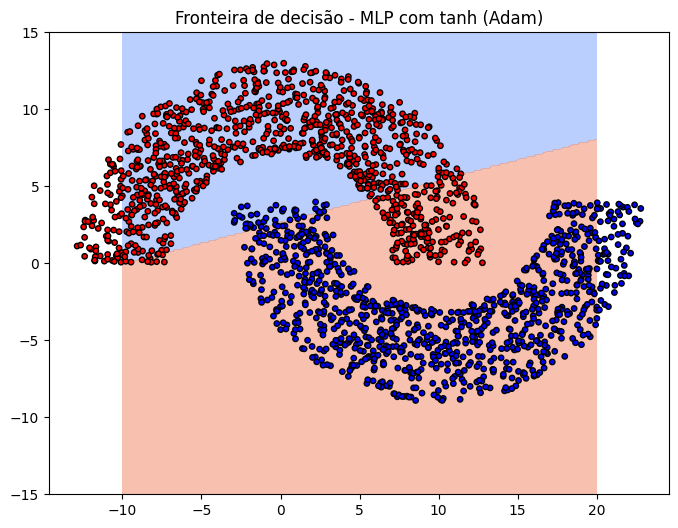

In [64]:
# Converte rótulos de teste
dteste = 2*dteste - 1

J_teste, yteste = redeMLP_teste(xteste, dteste, W_final, Nn, Nteste)
y_pred = np.where(yteste >= 0, 1, -1)
erro = np.mean(y_pred != dteste)
print(f"Taxa de erro no teste: {erro*100:.2f}%")

# Fronteira de decisão
x1g, x2g = np.meshgrid(np.linspace(-10, 20, 200), np.linspace(-15, 15, 200))
Xgrid = np.column_stack((x1g.ravel(), x2g.ravel()))
_, ygrid = redeMLP_teste(Xgrid, np.zeros((Xgrid.shape[0], 1)), W_final, Nn, Xgrid.shape[0])
ygrid = ygrid.reshape(x1g.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.contourf(x1g, x2g, ygrid, levels=[-1,0,1], cmap="coolwarm", alpha=0.6)
plt.scatter(xteste[:,0], xteste[:,1], c=dteste[:,0], cmap="bwr", edgecolors='k', s=15)
plt.title("Fronteira de decisão - MLP com tanh (Adam)")
plt.show()
